In [97]:
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern"})
import numpy as np

# Elastic behaviour

The solution of the general Ogden's model for the uniaxial tension, which in our $n$ th order case looks like

**$1^{\text{st}}$ Piola-Krichoff**

$$
P = \sum_{k=1}^n \frac{2\mu_k}{\alpha_k}(\lambda^{\alpha_k - 1} - \lambda^{-\frac{\alpha_k}{2} - 1}).
$$

**Cauchy stress**

$$
\sigma = P\cdot\lambda = \frac{2\mu_k}{\alpha_k}(\lambda^{\alpha_k} - \lambda^{-\frac{\alpha_k}{2}}).
$$

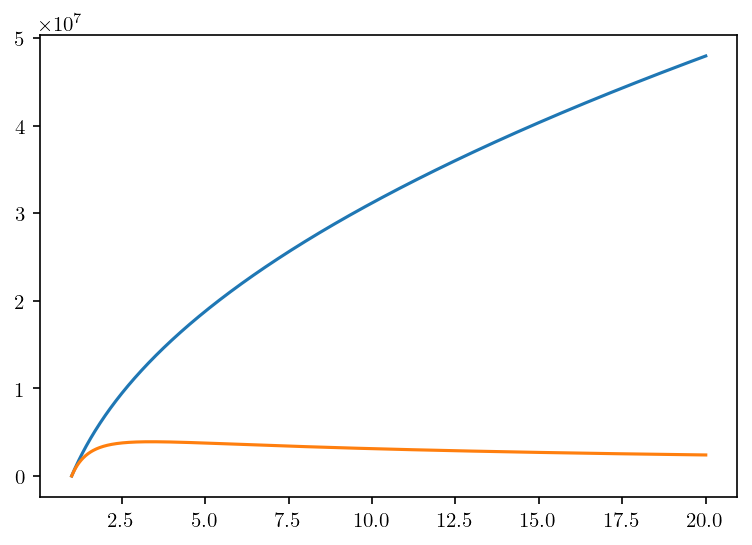

In [98]:
mu1 = 3e6
a1 = 0.5

def sig(𝜆, mu1, a1):
    return 2*mu1/a1 * (𝜆**(a1) - 𝜆**(-a1/2))

def P(𝜆, mu1, a1):
    return 2*mu1/a1 * (𝜆**(a1-1) - 𝜆**(-a1/2 - 1))


𝜆_range = np.linspace(1,20,1000)

plt.figure(figsize=(6,4), dpi=150)
plt.plot(𝜆_range, sig(𝜆_range, mu1, a1))
plt.plot(𝜆_range, P(𝜆_range, mu1, a1))
plt.show()

# Parameters of the viscous effect

Load measurement data from csv

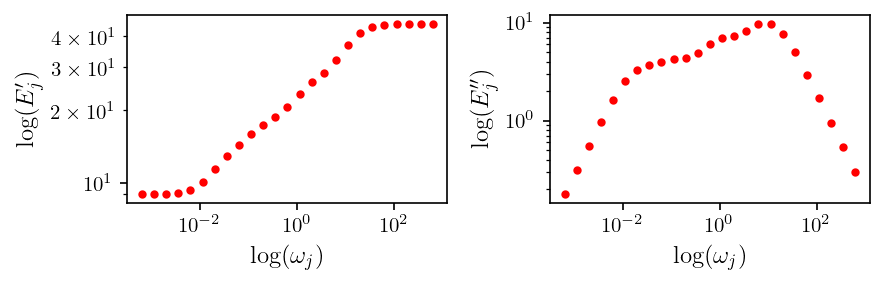

In [99]:
f, E_loss_true = np.loadtxt('loss.csv', delimiter=',').T
f, E_storage_true = np.loadtxt('storage.csv', delimiter=',').T

omega = 2*np.pi*f

fig, ax = plt.subplots(1,2,figsize=(6,2),dpi=150)
ax[0].scatter(omega,E_storage_true,color='red',marker='.')
ax[1].scatter(omega,E_loss_true,color='red',marker='.')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[0].set_xlabel(r"log($\omega_j$)",fontsize=12)
ax[0].set_ylabel(r"log($E'_j$)",fontsize=12)
ax[1].set_xlabel(r"log($\omega_j$)",fontsize=12)
ax[1].set_ylabel(r"log($E''_j$)",fontsize=12)
plt.tight_layout()
plt.show()

In [100]:
E_storage_true[-5:]

array([44.55302758, 44.85623857, 44.95429152, 44.98552082, 44.99541879])

In [101]:
E_0 = 45

The storage and the loss modulus expressed, with the help of the Prony parameters

$$
E'(\omega) = 
E_{\infty} + \sum_{i=1}^N \frac{\tau_i^2 \omega^2}{1+\tau_i^2 \omega^2}E_i
$$

$$
E''(\omega) = 
\sum_{i=1}^N \frac{\tau_i \omega}{1+\tau_i^2 \omega^2}E_i
$$

Define the quality function for the parameter fitting task, into the $n=25$ "measurement" point

$$
Q\left(\{E_i\}_{i=1}^N,\{\tau_i\}_{i=1}^N\right) = 
\frac{1}{n}\sum_{j=1}^n \left[\left(1-\frac{E'(\omega_j)}{E'_j}\right)^2 + \left(1-\frac{E''(\omega_j)}{E''_j}\right)^2\right]
$$

In [102]:
def E_storage(omega,E,tau):
    assert len(E) == len(tau)
    N = len(E) - 1
    # calc E_inf
    E_inf = E_0
    for i in range(N):
        E_inf = E_inf - E[i]
    # calc E_storage
    ret = E_inf
    for i in range(N):
        ret += tau[i]**2 * omega**2 / (1 + omega**2 * tau[i]**2) * E[i]
    return ret

def E_loss(omega,E,tau):
    assert len(E) == len(tau)
    N = len(E) - 1
    ret = 0
    for i in range(N):
        ret += tau[i] * omega / (1 + omega**2 * tau[i]**2) * E[i]
    return ret

def Q(params):
    assert len(params) % 2 == 0
    N = len(params) // 2
    E = params[0:N]
    tau = params[N:]
    return np.mean((1 - E_loss(omega,E,tau)/E_loss_true)**2 + (1 - E_storage(omega,E,tau)/E_storage_true)**2) 

In [57]:
from tqdm import tqdm
from scipy.optimize import minimize

Q_list = []
for N in tqdm(range(1,20)):
    E = [E_storage_true[0]/2] * N
    tau = [1] * N
    initial_guess = E + tau
    bounds = [(0, None)] * len(initial_guess)
    result = minimize(Q, initial_guess, bounds=bounds)
    Q_list += [result.fun*100]

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:19<00:00,  1.04s/it]


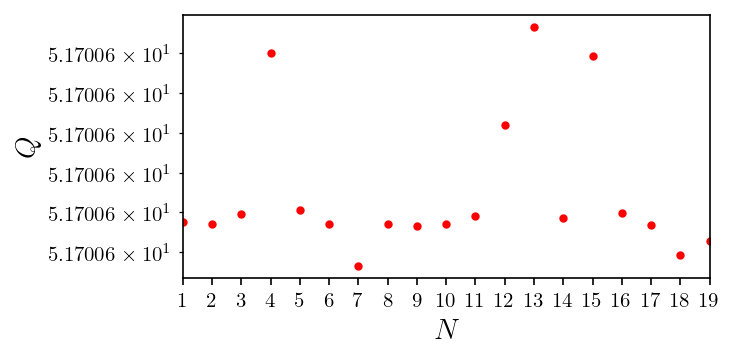

In [95]:
plt.figure(figsize=(5,2.5), dpi=150)
plt.scatter(range(1,20), Q_list,color='red',marker='.')
plt.xlabel(r"$N$", fontsize=14)
plt.ylabel(r"$Q$", fontsize=14)
plt.yscale('log')
plt.xticks(range(1,20))
plt.xlim(1,19)
plt.tight_layout()
plt.show()

In [104]:
N = 4 # order of the Prony series

E = [E_storage_true[0]/2] * N
tau = [1] * N

initial_guess = E + tau
bounds = [(0, None)] * len(initial_guess)

from scipy.optimize import minimize
result = minimize(Q, initial_guess, bounds=bounds)

n = (len(result.x)) // 2
E = result.x[0:n]
tau = result.x[n:]

print(f'E = {E}')
print(f'tau = {tau}')
print(f'Q = {result.fun*100} [%]')

E = [ 5.07624641  5.07637389 25.73832507  4.50230911]
tau = [23.22319367 23.22321766  0.15038742  1.        ]
Q = 5.677807375938193 [%]


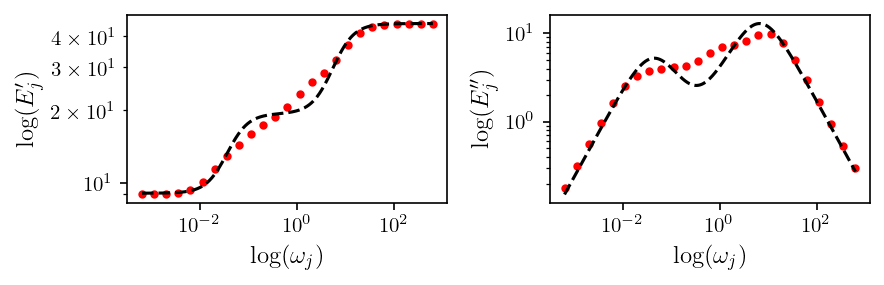

In [105]:
omega_range = np.logspace(np.log10(omega[0]),np.log10(omega[-1]),1000)

fig, ax = plt.subplots(1,2,figsize=(6,2),dpi=150)
ax[0].scatter(omega,E_storage_true,color='red',marker='.')
ax[1].scatter(omega,E_loss_true,color='red',marker='.')
ax[0].plot(omega_range,E_storage(omega_range,E,tau),color='black',ls='--')
ax[1].plot(omega_range,E_loss(omega_range,E,tau),color='black',ls='--')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[0].set_xlabel(r"log($\omega_j$)",fontsize=12)
ax[0].set_ylabel(r"log($E'_j$)",fontsize=12)
ax[1].set_xlabel(r"log($\omega_j$)",fontsize=12)
ax[1].set_ylabel(r"log($E''_j$)",fontsize=12)
plt.tight_layout()
plt.show()

$$
E_{\infty} = E_0 - \sum_{i=1}^N E_i
$$

In [106]:
E_inf = E_0 + np.sum(E)

$$e_i = \frac{E_i}{E_0}$$

In [107]:
e = E/E_0

# Stress response

Uniaxial loading is prescirbed, and the engineering strain time evolution is given as

$$
\varepsilon = 15t\cdot e^{-2t}-0.09t.
$$

Therefore, the uniaxial strech can be expressed as

$$
\lambda = \varepsilon + 1 = 15t\cdot e^{-2t}-0.09t + 1
$$

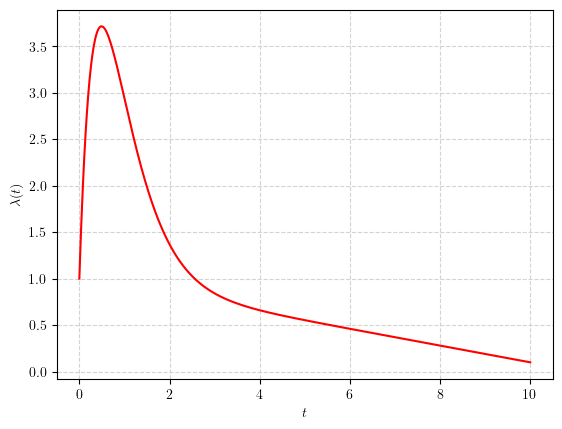

In [79]:
t = np.linspace(0,10,1000)

def eps(t):
    return 15*t*np.e**(-2*t)-0.09*t

def λ(t):
    return eps(t) + 1


plt.plot(t,λ(t),color='red')
plt.xlabel(r'$t$')
plt.ylabel(r'$\lambda(t)$')
plt.grid(ls='--',color='lightgray')
plt.show()

Remember, the solution of the 1st order Ogden model for uniaxial extension is:

$$
\sigma_0(t) = \frac{2\mu_1}{\alpha_1}(\lambda^{\alpha_1}(t) - \lambda^{-\frac{\alpha_1}{2}}(t)).
$$

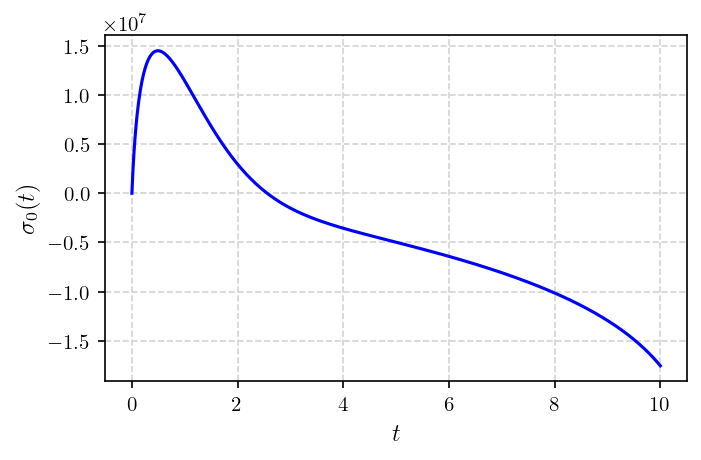

In [80]:
plt.figure(figsize=(5,3), dpi=150)
plt.plot(t,sig(λ(t),mu1,a1),color='blue')
plt.xlabel(r'$t$',fontsize=12)
plt.ylabel(r'$\sigma_0(t)$',fontsize=12)
plt.grid(ls='--',color='lightgray')
plt.show()

The deviatoric part of the Cauchy stress tensor can be expressed as

$$
\boldsymbol{s}_0(t) = 
\sigma_0(t)
\begin{bmatrix}
    2/3 & 0 & \\
    0 & -1/3 & 0\\
    0 & 0 & -1/3\\
\end{bmatrix}
$$

We know from the lecture that

$$
\boldsymbol{s}(t) = \boldsymbol{s}_0(t) - 
\text{dev}\left[
    \boldsymbol{F}(t)
        \left(
            \sum_{i=1}^N \frac{e_i}{\tau_i} \int_0^t \boldsymbol{F}^{-1}(t-s) \boldsymbol{s}_0(t-s) \boldsymbol{F}^{-T}(t-s)e^{-\frac{s}{\tau_i}}\text{d}s
        \right)
    \boldsymbol{F}^T(t)
\right]
$$


We know that the deformation gradient for uniaxial extension looks like

$$
\boldsymbol{F}(t) = \boldsymbol{F}^T(t) = 
\begin{bmatrix}
    \lambda(t) & 0 & 0\\
    0&\lambda^{-1/2}(t)&0\\
    0&0&\lambda^{-1/2}(t)\\
\end{bmatrix}\quad\&\quad
\boldsymbol{F}^{-1}(t) =  \boldsymbol{F}^{-T}(t)=
\begin{bmatrix}
    \lambda^{-1}(t) & 0 & 0\\
    0&\lambda^{1/2}(t)&0\\
    0&0&\lambda^{1/2}(t)\\
\end{bmatrix}
$$

First let's calculate the following term:

$$
\boldsymbol{F}^{-1}(t-s) \boldsymbol{s}_0(t-s) \boldsymbol{F}^{-T}(t-s) = 
\sigma_0(t-s)
\begin{bmatrix}
    \frac{2}{3}\lambda^{-2}(t-s) & 0 & 0\\
    0&-\frac{1}{3}\lambda(t-s)&0\\
    0&0&-\frac{1}{3}\lambda(t-s)\\
\end{bmatrix} 
$$

Convolution for the terms of the Prony series

In [81]:
def dev(M):
    return M - np.sum(M,axis=0)/3

def plot_diag_tensor(M,name):
    plt.figure(figsize=(4,3), dpi=150)
    plt.plot(t, M[0]/1e6, label=f'${name}' + r'_{11}$', color='blue')
    plt.plot(t, M[1]/1e6, label=f'${name}' + r'_{22}$', color='red',ls='--')
    plt.plot(t, M[2]/1e6, label=f'${name}' + r'_{33}$', color='green' ,ls=':')
    plt.xlabel(r'$t$ [s]')
    plt.ylabel(f'${name}' + r'_{ij}$ [Mpa]')
    plt.grid(ls='--', color='lightgray')
    plt.legend()
    plt.show()

def conv(f,g,t):
    dt = t[1] - t[0]
    ret = [np.sum(f(t[k] - t[:k]) * g(t[:k]) * dt,axis=-1) for k in range(len(t))]
    return np.array(ret).T

In [ ]:
def F(t):
    return np.array([λ(t), λ(t)**(-1/2), λ(t)**(-1/2)])

def F_inv(t):
    return np.array([λ(t)**(-1), λ(t)**(1/2), λ(t)**(1/2)])

def sig0(t):
    return np.column_stack((
        sig(λ(t),mu1,a1), 
        np.zeros_like(t), 
        np.zeros_like(t)
    )).T

def s0(t):
    return dev(sig0(t))


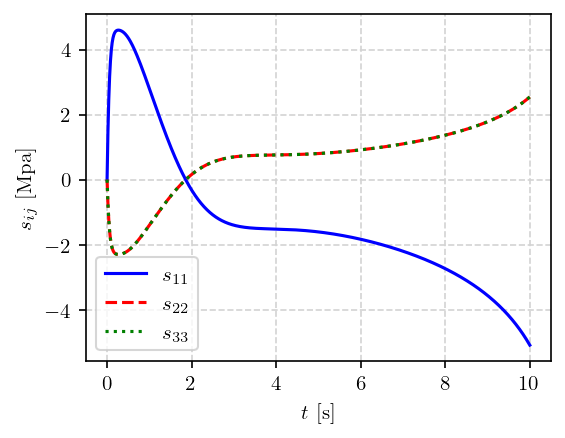

In [83]:
# placeholder for the middle term
SUM = np.zeros((3,len(t)))
for i in range(len(tau)):
    f = lambda t: F_inv(t)*s0(t)*F_inv(t)
    g = lambda t: np.e**(-t/tau[i])
    SUM += e[i]/tau[i] * conv(f,g,t)

# deviatoric stress
s = s0(t) - dev(F(t)*SUM*F(t))

plot_diag_tensor(s, 's')

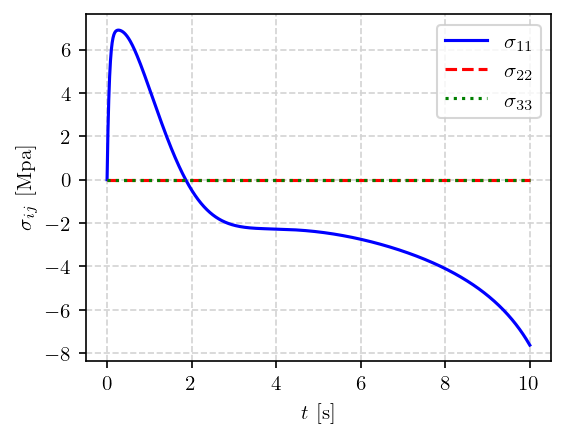

In [84]:
p = np.column_stack((-s[1],-s[1],-s[1])).T

plot_diag_tensor(s+p, r'\sigma')

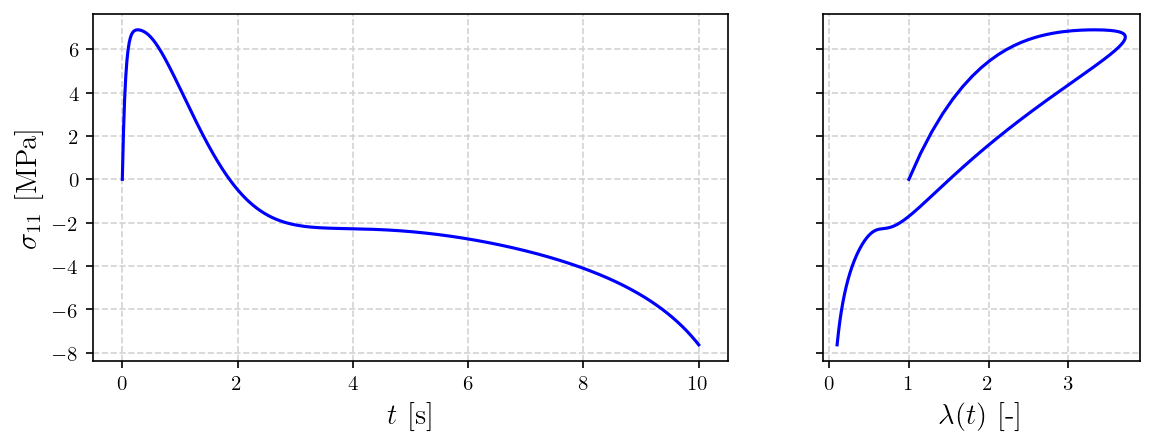

In [85]:
fig, ax = plt.subplots(1,2,figsize=(9,3),dpi=150,sharey=True,gridspec_kw={'width_ratios': [2, 1]},)
ax[0].plot(t, (s+p)[0]/1e6, color='blue')
ax[0].set_xlabel(r'$t$ [s]',fontsize=14)
ax[0].set_ylabel(r'$\sigma_{11}$ [MPa]',fontsize=14)
ax[1].plot(λ(t),(s+p)[0]/1e6,color='blue')
ax[1].set_xlabel(r'$\lambda(t)$ [-]',fontsize=14)
ax[0].grid(ls='--', color='lightgray')
ax[1].grid(ls='--', color='lightgray')
plt.show()

### With the derived formulas

$$
A_i = \int_0^t \frac{\sigma_0(t-s)}{\lambda^2(t-s)}\text{exp}\left(-\frac{s}{\tau_i}\right)\text{d}s
$$

$$
B_i = \int_0^t \lambda(t-s) \sigma_0(t-s) \text{exp}\left(-\frac{s}{\tau_i}\right)\text{d}s
$$

In [70]:
A,B = [], []

for i in range(len(tau)):
    # compute A
    f = lambda t: sig(λ(t),mu1,a1) / λ(t)**2
    g = lambda t: np.e**(-t/tau[i])
    A += [conv(f,g,t)]
    # compute B
    f = lambda t: λ(t)*sig(λ(t),mu1,a1)
    g = lambda t: np.e**(-t/tau[i])
    B += [conv(f,g,t)]

$$
\sigma_i = \frac{g_i}{\tau_i} \left( \frac{2\lambda^2(t)}{3}A_i + \frac{1}{3\lambda(t)}B_i \right)
$$

In [71]:
sigma = []
for i in range(len(tau)):
    sigma += [e[i]/tau[i] * (2*λ(t)**2 / 3 * A[i] + 1/3/λ(t) * B[i])]

$$
\sigma(t) = \sigma_0(t) - \sum_{i=1}^{N}\sigma_i
$$

In [72]:
sigma__ = sig(λ(t),mu1,a1) - np.sum(sigma,axis=0)

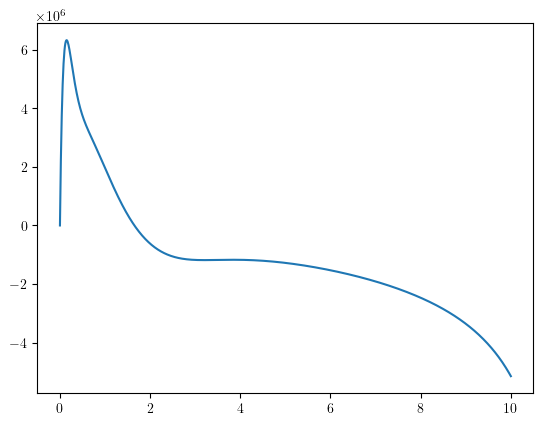

In [73]:
plt.plot(t,sigma__)